<a href="https://colab.research.google.com/github/DanielOlson/PublicNotebooks/blob/main/Covariance_Matrix_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covariance Matrix Sampling

The [SWAG paper](https://arxiv.org/pdf/1902.02476) tries to estimate the covariance matrix of a neural network's parameters when within a sufficiently quadratic local minima (as one often does in Bayesian Deep Learning). Their estimate method samples weights at different training steps (samples are taken after the model has already converged), and then randomly mixes those samples in order to sample a low-rank estimate of the parameter co-varaince. It was not entirely obvious to me 'how' this sort of sampling technique could be used to estimate parameter covariance; this notebook was meant to meant to provide some investigation into this sort of estimation.

This notebook was written by Daniel R. Olson and Jeremiah Gaiser.

## plan

1.   Create a gaussian distribution that will act as a stand in for a parameter distribution inside a local minima.
2.   Test our ability to reconstruct the distribution's variance (i.e diag(covariance)) through sampling the distribution
3.   Test our ability to reconstruct the distribution's covariance by thoroughly sampling the distribution
4.   Test our ability to reconstruct the covariance using the SWAG sampling technique where $K=T$
5.   Repeat 4., but for fixed $K$ where $K \leq T$



### Distribution Creation

First we will create a Gaussian with mean 0, and a structured (but random) covariance.

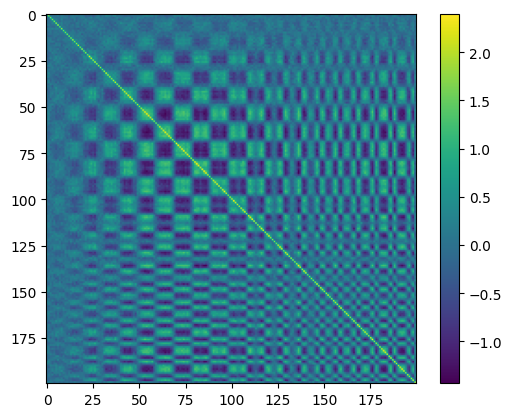

In [ ]:

import torch
import matplotlib.pyplot as plt

dim = 200
gamma = 0.1

dist_cov = torch.sin(torch.arange(dim*dim).view(dim, dim)/dim * 5/(dim) * torch.sin(3.14 * torch.arange(dim*dim).view(dim, dim)) + torch.randn(dim, dim)) * (torch.randn(dim, dim).abs())
dist_cov = dist_cov.abs()**0.5 * dist_cov.sign()
dist_cov = dist_cov - dist_cov.mean()
dist_cov = dist_cov / dist_cov.std()
dist_cov = (dist_cov * gamma)# + (torch.eye(dim) * 2.0)
dist_cov = (dist_cov @ dist_cov.T)

plt.imshow(dist_cov)
plt.colorbar()
plt.show()

true_distribution = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), dist_cov)

true_var = torch.diag(dist_cov)




### Test convergence of variance (i.e diag(cov)) when sampling

In [ ]:
for n in [2, 50, 100, 1000, 10000]:
    theta = true_distribution.sample((n,))
    theta_var = torch.var(theta, dim=0)
    print(f"Mean difference in sample variance vs true variance for {n} samples: {torch.mean((theta_var - true_var)**2)**0.5}")


Mean difference in sample variance vs true variance for 2 samples: 2.0028703212738037
Mean difference in sample variance vs true variance for 50 samples: 0.41643261909484863
Mean difference in sample variance vs true variance for 100 samples: 0.2867202162742615
Mean difference in sample variance vs true variance for 1000 samples: 0.0937730073928833
Mean difference in sample variance vs true variance for 10000 samples: 0.028143849223852158


### Test convergence of covariance without SWAG method.

Here we reconstruct the covariance matrix by sampling the distribution many times, and then creating a divergence matrix for our samples, and use that divergence matrix to create recreate the original covariance matrix. We don't use a live mean of $\theta$ during the construction of the divergence matrix, but we suspect this result approximatley holds when using a live mean of $\theta$.

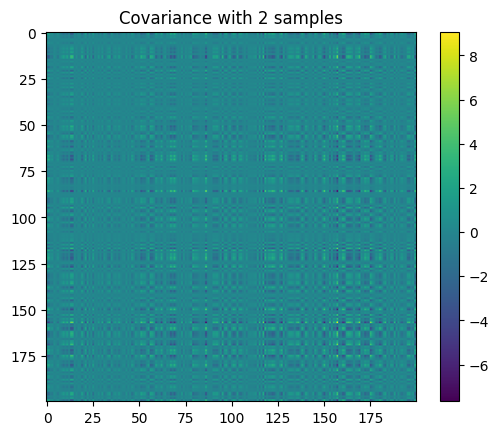

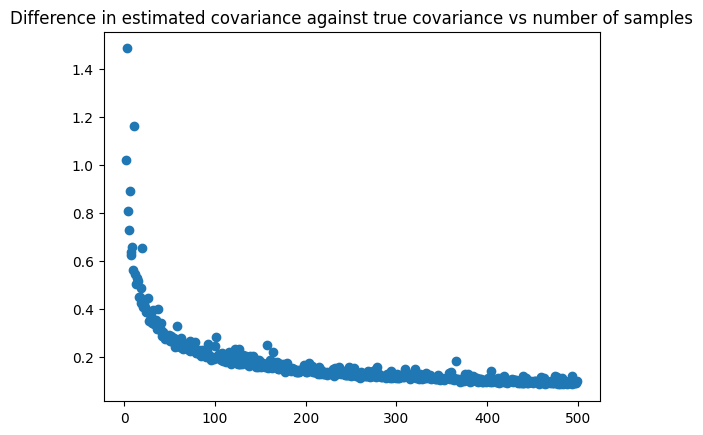

tensor(0.1753)


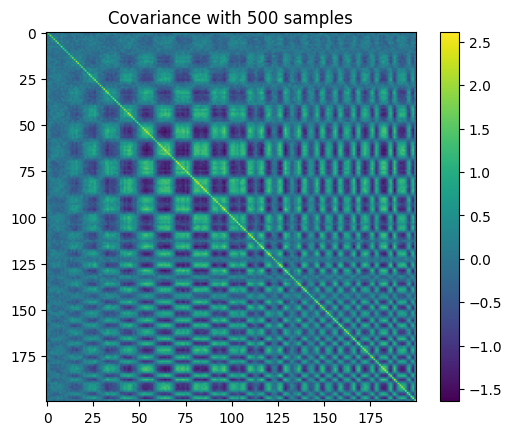

In [ ]:
x = []
y = []
num_samples = 500
for n in torch.arange(2, num_samples):
    theta = true_distribution.sample((n,))
    theta_var = torch.var(theta, dim=0)

    theta_covariance = torch.eye(dim, dim) * theta_var

    # [i,dim]
    divergence = (theta.mean(dim=0) - theta)
    low_rank_cov = divergence.T @ divergence / n

    x.append(n)
    y.append(torch.mean((dist_cov - low_rank_cov)**2)**0.5)

    if n == 2:
        plt.imshow(low_rank_cov)
        plt.title("Covariance with 2 samples")
        plt.colorbar()
        plt.show()

    #print(f"Difference in estimated covariance vs true covariance for {n} samples: {torch.norm(dist_cov - low_rank_cov)}")

plt.scatter(x, y)
plt.title("Difference in estimated covariance against true covariance vs number of samples")
plt.show()
print(sum(y[:-10]) / len(y[:-10]))

plt.imshow(low_rank_cov)
plt.title(f"Covariance with {num_samples} samples")
plt.colorbar()
plt.show()





### SWAG styled sampling

Now we use the SWAG sampling method.
Given a set of observed parameters, ${\theta_i}$ we construct a divergence matrix and then use that divergence matrix to sample *new* (not from the true distribution) parameters using the method described in the SWAG paper. We then test the covariance of the sampled

This experiment uses the complete divergence matrix. We sample many *new* parameters, and use those samples to reconstruct the original covariance matrix.


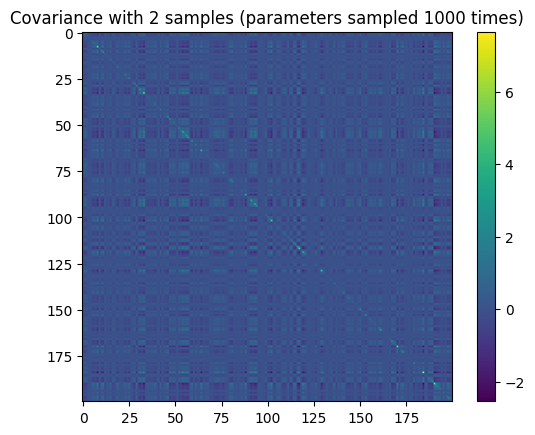

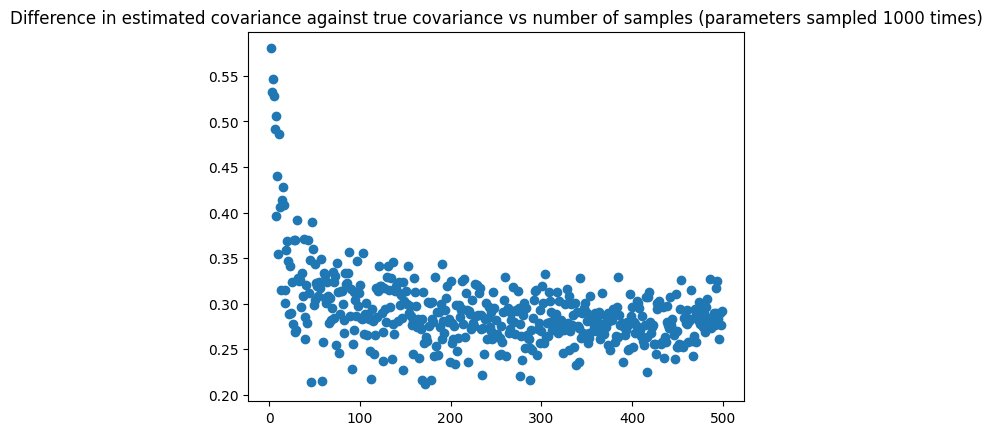

tensor(0.2919)


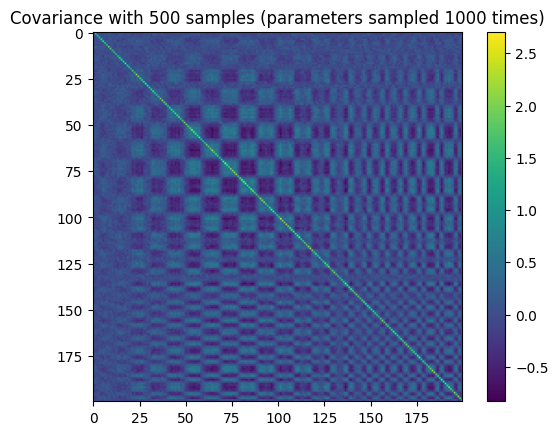

In [ ]:
x = []
y = []
num_samples = 500
num_theta_samples = 1000

def sample_theta(mean, var, divergence, num_samples):
    z1 = torch.randn(num_samples, dim)
    z2 = torch.randn(num_samples, len(divergence))


    var_samples = (1/(2**0.5) * var**(0.5))[None,:] * z1
    cov_samples = (1/(2 * len(divergence))**0.5) * ((z2 @ divergence))
    new_theta = mean + var_samples + cov_samples
    return new_theta

def estimate_covariance(theta_samples):
    divergence = (theta_samples.mean(dim=0) - theta_samples)
    return divergence.T @ divergence / len(theta_samples)

for n in torch.arange(2, num_samples):
    theta = true_distribution.sample((n,))

    theta_mean = theta.mean(dim=0)
    theta_var = torch.var(theta, dim=0)
    divergence = (theta.mean(dim=0) - theta)

    sample = sample_theta(theta_mean, theta_var, divergence, num_theta_samples)

    sample_covariance = estimate_covariance(sample)

    #print(sample_covariance.shape, sample.shape)

    x.append(n)
    y.append(torch.mean((dist_cov - sample_covariance)**2)**0.5)

    if n == 2:
        plt.imshow(sample_covariance)
        plt.title(f"Covariance with 2 samples (parameters sampled {num_theta_samples} times)")
        plt.colorbar()
        plt.show()

    #print(f"Difference in estimated covariance vs true covariance for {n} samples: {torch.norm(dist_cov - low_rank_cov)}")

plt.scatter(x, y)
plt.title(f"Difference in estimated covariance against true covariance vs number of samples (parameters sampled {num_theta_samples} times)")
plt.show()
print(sum(y[:-10]) / len(y[:-10]))


plt.imshow(sample_covariance)
plt.title(f"Covariance with {num_samples} samples (parameters sampled {num_theta_samples} times)")
plt.colorbar()
plt.show()


### Sampling using SWAG with fixed K

Here we perform the same experiment as the previous cell, except we limit the size of the divergence matrix, using only the last $K$ divergence vectors.


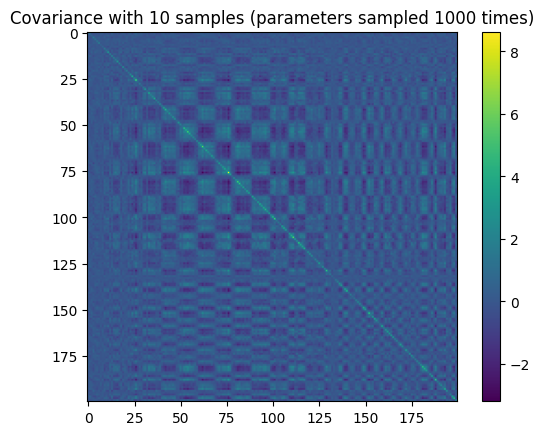

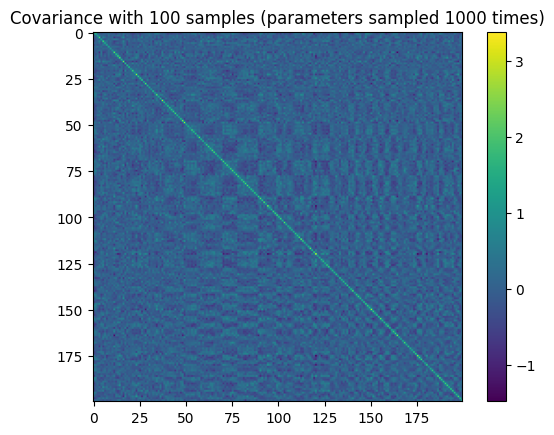

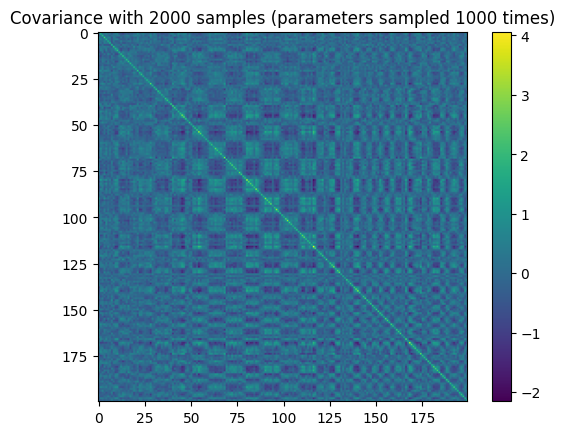

In [ ]:
x = []
y = []
num_samples = 500
num_theta_samples = 1000
k = 10 # adjust if you want


for n in [10, 100, 2000]:
    theta = true_distribution.sample((n,))

    theta_mean = theta.mean(dim=0)
    theta_var = torch.var(theta, dim=0)
    divergence = (theta.mean(dim=0) - theta)

    sample = sample_theta(theta_mean, theta_var, divergence[:k], num_theta_samples)

    sample_covariance = estimate_covariance(sample)

    #print(sample_covariance.shape, sample.shape)

    x.append(n)
    y.append(torch.mean((dist_cov - sample_covariance)**2)**0.5)

    plt.imshow(sample_covariance)
    plt.title(f"Covariance with {n} samples (parameters sampled {num_theta_samples} times)")
    plt.colorbar()
    plt.show()


### Sampling using SWAG with fixed K and fewer samples

Here we perform the same experiment as the previous cell, except now we restrict the number of parameter observations to a much smaller number (50).


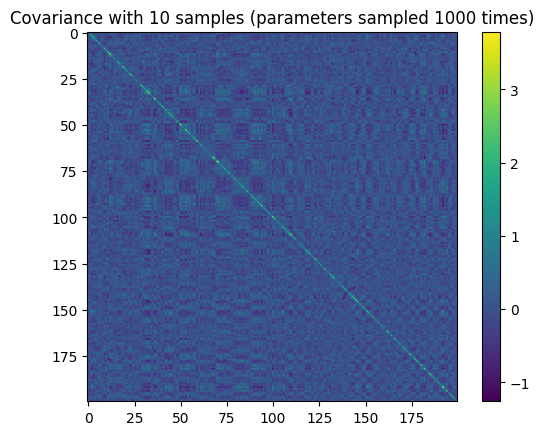

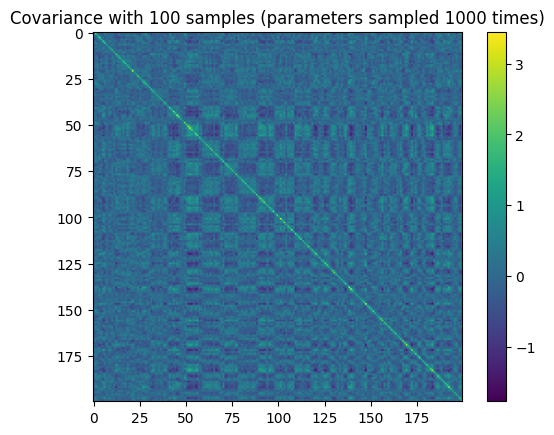

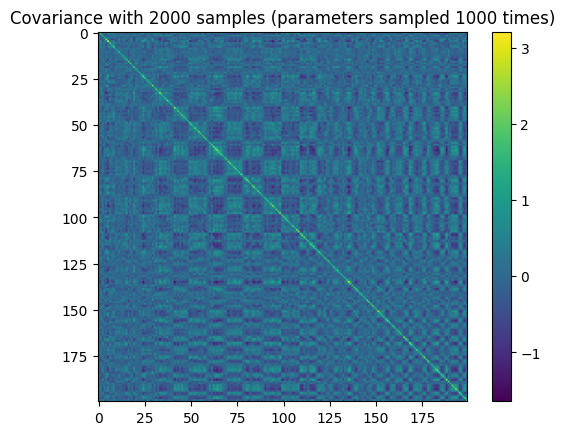

In [ ]:
x = []
y = []
num_samples = 50
num_theta_samples = 1000
k = 10 # adjust if you want


for n in [10, 100, 2000]:
    theta = true_distribution.sample((n,))

    theta_mean = theta.mean(dim=0)
    theta_var = torch.var(theta, dim=0)
    divergence = (theta.mean(dim=0) - theta)

    sample = sample_theta(theta_mean, theta_var, divergence[:k], num_theta_samples)

    sample_covariance = estimate_covariance(sample)

    #print(sample_covariance.shape, sample.shape)

    x.append(n)
    y.append(torch.mean((dist_cov - sample_covariance)**2)**0.5)

    plt.imshow(sample_covariance)
    plt.title(f"Covariance with {n} samples (parameters sampled {num_theta_samples} times)")
    plt.colorbar()
    plt.show()
